In [1]:
import torch
print("Is CUDA available?:", torch.cuda.is_available())
print("Number of GPUs:", torch.cuda.device_count())

Is CUDA available?: True
Number of GPUs: 1


In [2]:
%%capture
!pip install unsloth
# Also get the latest nightly Unsloth!
!pip uninstall unsloth -y && pip install --upgrade --no-cache-dir "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git

In [1]:
from unsloth import FastLanguageModel
import torch
max_seq_length = 2048*2 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

# 4bit pre quantized models we support for 4x faster downloading + no OOMs.
fourbit_models = [
    "unsloth/Llama-3.2-1B-bnb-4bit",           # NEW! Llama 3.2 models
    "unsloth/Llama-3.2-1B-Instruct-bnb-4bit",] # More models at https://huggingface.co/unsloth

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Llama-3.2-1B-Instruct", # or choose "unsloth/Llama-3.2-1B-Instruct"
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,)
    # token = "hf_...", # use one if using gated models like meta-llama/Llama-2-7b-hf
baseline_model = model

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
==((====))==  Unsloth 2024.10.7: Fast Llama patching. Transformers = 4.44.2.
   \\   /|    GPU: Tesla V100-PCIE-16GB. Max memory: 15.766 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.4.1+cu121. CUDA = 7.0. CUDA Toolkit = 12.1.
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.28.post1. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth


Unsloth: We fixed a gradient accumulation bug, but it seems like you don't have the latest transformers version!
Please update transformers, TRL and unsloth via:
`pip install --upgrade --no-cache-dir unsloth git+https://github.com/huggingface/transformers.git git+https://github.com/huggingface/trl.git`


In [2]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 16, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)

Unsloth 2024.10.7 patched 16 layers with 16 QKV layers, 16 O layers and 16 MLP layers.


In [3]:
from unsloth.chat_templates import get_chat_template

tokenizer = get_chat_template(
    tokenizer,
    chat_template = "llama-3.1",
)

def formatting_prompts_func(examples):
    questions = examples['question']
    answers = examples['answer']
    convos = []
    for question, answer in zip(questions, answers):
        convos.append([{"role": "user", "content": question}, {"role": "assistant", "content": answer}])
    texts = [tokenizer.apply_chat_template(convo, tokenize = False, add_generation_prompt = False) for convo in convos]
    return { "text" : texts, }



In [1]:
from datasets import load_dataset
dataset = load_dataset("sentence-transformers/eli5")

In [2]:
from datasets import DatasetDict
train_test_split = dataset['train'].train_test_split(test_size=0.1)

# Step 2: Split the 'train' part (80%) into 'train' (90% of 80%) and 'validation' (10% of 80%)
train_valid_split = train_test_split['train'].train_test_split(test_size=0.1)  # 10% for validation

# Step 3: Update the DatasetDict to include 'train', 'validation', and 'test' sets
dataset = DatasetDict({
    'train': train_valid_split['train'],  # 90% of 80% => 72% of the original dataset
    'validation': train_valid_split['test'],  # 10% of 80% => 8% of the original dataset
    'test': train_test_split['test']  # 20% of the original dataset
})

In [11]:
dataset

DatasetDict({
    train: Dataset({
        features: ['question', 'answer'],
        num_rows: 263634
    })
    validation: Dataset({
        features: ['question', 'answer'],
        num_rows: 29293
    })
    test: Dataset({
        features: ['question', 'answer'],
        num_rows: 32548
    })
})

In [ ]:
from unsloth.chat_templates import standardize_sharegpt
#dataset = standardize_sharegpt(dataset['train'])
dataset = dataset.map(formatting_prompts_func, batched = True,)

In [ ]:
dataset['train'][0]

In [ ]:
from trl import SFTTrainer
from transformers import TrainingArguments, DataCollatorForSeq2Seq
from unsloth import is_bfloat16_supported

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = dataset['train'],
    eval_dataset=dataset['test'],
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    data_collator = DataCollatorForSeq2Seq(tokenizer = tokenizer),
    dataset_num_proc = 2,
    packing = False, # Can make training 5x faster for short sequences.
    args = TrainingArguments(
        per_device_train_batch_size = 8,
        gradient_accumulation_steps = 8,
        warmup_steps = 5,
        # num_train_epochs = 1, # Set this for 1 full training run.
        max_steps = 3000,
        learning_rate = 2e-4,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        report_to = "none", # Use this for WandB etc
        eval_strategy="steps",  # You can also use 'epoch' if preferred
        eval_steps=250,
        metric_for_best_model="eval_loss",
    ),
)


In [ ]:
from unsloth.chat_templates import train_on_responses_only
trainer = train_on_responses_only(
    trainer,
    instruction_part = "<|start_header_id|>user<|end_header_id|>\n\n",
    response_part = "<|start_header_id|>assistant<|end_header_id|>\n\n",
)

In [ ]:
space = tokenizer(" ", add_special_tokens = False).input_ids[0]
tokenizer.decode([space if x == -100 else x for x in trainer.train_dataset[0]["labels"]])
space

In [ ]:
trainer_stats = trainer.train()

In [ ]:
peft_model = trainer_stats.model
output_dir = "C:/Users/luan/Desktop/peft_weights"
peft_model.save_pretrained(output_dir)

In [ ]:
tokenizer.save_pretrained(output_dir)

In [1]:
from transformers import AutoModelForCausalLM, AutoTokenizer, AutoProcessor
from peft import PeftModel, PeftConfig

# Load the base model
base_model_id = "unsloth/Llama-3.2-1B-Instruct"
base_model = AutoModelForCausalLM.from_pretrained(base_model_id)

# Load the PEFT configuration
peft_model_id = "C:/Users/luan/Desktop/peft_weights"
config = PeftConfig.from_pretrained(peft_model_id)

# Load the PEFT model
model = PeftModel.from_pretrained(base_model, peft_model_id)

# Load the tokenizer and processor
tokenizer = AutoTokenizer.from_pretrained(peft_model_id)
processor = AutoProcessor.from_pretrained(base_model_id)

In [5]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
model.eval()
model.to(device)
base_model.to(device)

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 2048)
    (layers): ModuleList(
      (0-15): 16 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): lora.Linear(
            (base_layer): Linear(in_features=2048, out_features=2048, bias=False)
            (lora_dropout): ModuleDict(
              (default): Identity()
            )
            (lora_A): ModuleDict(
              (default): Linear(in_features=2048, out_features=16, bias=False)
            )
            (lora_B): ModuleDict(
              (default): Linear(in_features=16, out_features=2048, bias=False)
            )
            (lora_embedding_A): ParameterDict()
            (lora_embedding_B): ParameterDict()
            (lora_magnitude_vector): ModuleDict()
          )
          (k_proj): lora.Linear(
            (base_layer): Linear(in_features=2048, out_features=512, bias=False)
            (lora_dropout): ModuleDict(
              (default): Identity()
   

In [18]:
question="The difference between a learning disability and an intellectual disability"
inputs = tokenizer(text=question, return_tensors="pt", padding=True, truncation=True).to(device)

        # Generate answers using the fine-tuned model
with torch.inference_mode():
    outputs = model.generate(
                **inputs,
                max_new_tokens=200,
                do_sample=True,
                temperature=0.6,
                top_p=0.8,
                repetition_penalty=1.2
            )

    base_outputs = base_model.generate(
                **inputs,
                max_new_tokens=200,
                do_sample=True,
                temperature=0.6,
                top_p=0.8,
                repetition_penalty=1.2
            )

        # Decode the generated answers
generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
base_generated_text = tokenizer.decode(base_outputs[0], skip_special_tokens=True)
print(f"Question : {question}")
print(f"Model Output: {generated_text}")
print("-" * 10)
print(f"Base Model Output: {base_generated_text}")
print("-" * 50)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question : The difference between a learning disability and an intellectual disability
Model Output: The difference between a learning disability and an intellectual disability is the level of mental functioning. Intellectual disabilities are characterized by severe limitations in cognitive abilities, such as difficulty with language or memory. Learning disabilities refer to difficulties that affect one's ability to learn new information through various methods (e.g., reading, writing) without necessarily having any underlying problems with intelligence.

Here’s some more specific examples:  * Dyslexia refers to a disorder which affects how you process written words into meaningful sentences and paragraphs; it can cause trouble understanding what someone has said if they don’t read their own speech out loud while speaking. This may be due to difficulties processing phonemes—small units within spoken sounds—and/or semantic skills—the way your brain interprets meaning from those sound pa

In [17]:
import random

# Assuming your test dataset is a list called 'test_data'
sampled_data = random.sample(dataset['test']['question'], 350)

NameError: name 'dataset' is not defined

In [28]:
import torch
from tqdm import tqdm

batch_size = 10  # Start with a small batch size
all_generated_texts = []
all_base_generated_texts = []
torch.manual_seed(42)

for i in tqdm(range(0, len(sampled_data), batch_size)):
    # Get the current batch of questions
    batch_questions = sampled_data[i:i + batch_size]

    try:
        # Tokenize and move to GPU
        inputs = processor(text=batch_questions, return_tensors="pt", padding=True, truncation=True).to(device)

        # Generate answers using the fine-tuned model
        with torch.inference_mode():
            outputs = model.generate(
                **inputs,
                max_new_tokens=200,
                do_sample=True,
                temperature=0.6,
                top_p=0.8,
                repetition_penalty=1.2,
                pad_token_id=tokenizer.eos_token_id 
            )

            base_outputs = base_model.generate(
                **inputs,
                max_new_tokens=200,
                do_sample=True,
                temperature=0.6,
                top_p=0.8,
                repetition_penalty=1.2,
                pad_token_id=tokenizer.eos_token_id 
            )

        # Decode the generated answers
        generated_texts = [tokenizer.decode(o, skip_special_tokens=True) for o in outputs]
        base_generated_texts = [tokenizer.decode(o, skip_special_tokens=True) for o in base_outputs]

        # Collect the results
        all_generated_texts.extend(generated_texts)
        all_base_generated_texts.extend(base_generated_texts)

        # Clear cache after each batch
        torch.cuda.empty_cache()

    except RuntimeError as e:
        if "CUDA out of memory" in str(e):
            print("CUDA OOM error. Consider reducing batch size.")
            torch.cuda.empty_cache()
        else:
            raise e

print(f"Generated {len(all_generated_texts)} answers from the fine-tuned model.")
print(f"Generated {len(all_base_generated_texts)} answers from the baseline model.")

  0%|          | 0/35 [00:00<?, ?it/s]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
  3%|▎         | 1/35 [00:12<07:13, 12.76s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
  6%|▌         | 2/35 [00:24<06:35, 11.98s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
  9%|▊         | 3/35 [00:36<06:34, 12.33s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
 11%|█▏        | 4/35 [00:46<05:53, 11.40s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
 14%|█▍        | 5/35 [00:59<05:56, 11.90s/it]Se

Generated 350 answers from the fine-tuned model.
Generated 350 answers from the baseline model.


In [32]:
import pandas as pd

# Create a DataFrame for easier analysis
output_df = pd.DataFrame({
    "question": sampled_data,
    "baseline_answer": all_base_generated_texts,
    "fine_tuned_answer": all_generated_texts
})

# Save to a CSV file
output_df.to_csv("generated_answers.csv", index=False)

In [4]:
import pandas as pd
output_df=pd.read_csv("generated_answers.csv")

In [2]:
output_df

,question,baseline_answer,fine_tuned_answer
0,Has there ever been a point in time when the K...,Has there ever been a point in time when the K...,Has there ever been a point in time when the K...
1,How can NASA so accurately pinpoint the locati...,How can NASA so accurately pinpoint the locati...,How can NASA so accurately pinpoint the locati...
2,Is it true that Modern Man evolved in Africa?,Is it true that Modern Man evolved in Africa? ...,Is it true that Modern Man evolved in Africa? ...
3,Can the wind all over the world just stop? If ...,Can the wind all over the world just stop? If ...,Can the wind all over the world just stop? If ...
4,How is it possible that we feel heat from the ...,How is it possible that we feel heat from the ...,How is it possible that we feel heat from the ...
...,...,...,...
345,Why do all countries have a rectangular flag? ...,Why do all countries have a rectangular flag? ...,Why do all countries have a rectangular flag? ...
346,Why did the Saxons call it England?,Why did the Saxons call it England? They were ...,"Why did the Saxons call it England? The name ""..."
347,"Are there precious resources (ie gold, copper,...","Are there precious resources (ie gold, copper,...","Are there precious resources (ie gold, copper,..."
348,Can lorentz contractions and time dilation mak...,Can lorentz contractions and time dilation mak...,Can lorentz contractions and time dilation mak...


In [ ]:
#check whether LLAMA change its answering style due to fine tune by ELI5

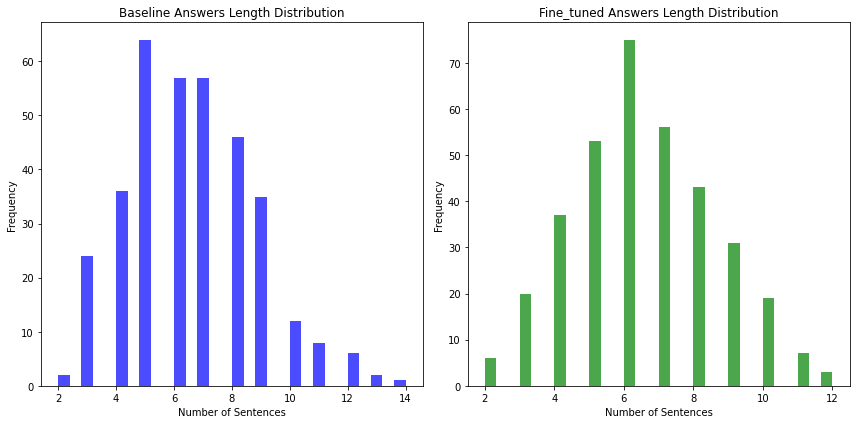

In [7]:
from nltk.tokenize import sent_tokenize
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'dataset' is your loaded DatasetDict
# Example: dataset = DatasetDict.load_from_disk('path_to_your_dataset')

# Extract the first 1000 QA pairs
qa_pairs = output_df

# Initialize lists to store lengths
question_lengths = []
answer_lengths = []

# Calculate sentence lengths for each QA pair
for pair in range(len(qa_pairs)):
    question = qa_pairs['baseline_answer'][pair]
    answer = qa_pairs['fine_tuned_answer'][pair]
    
    # Count sentences in question and answer
    question_length = len(sent_tokenize(question))
    answer_length = len(sent_tokenize(answer))
    
    # Append lengths to lists
    question_lengths.append(question_length)
    answer_lengths.append(answer_length)

# Create a DataFrame for easier analysis
lengths_df = pd.DataFrame({
    'Question Length': question_lengths,
    'Answer Length': answer_lengths
})

# Save lengths to a CSV file (optional)
lengths_df.to_csv('qa_lengths.csv', index=False, encoding='utf-8')

# Visualization
plt.figure(figsize=(12, 6))

# Question lengths
plt.subplot(1, 2, 1)
plt.hist(question_lengths, bins=30, color='blue', alpha=0.7)
plt.title('Baseline Answers Length Distribution')
plt.xlabel('Number of Sentences')
plt.ylabel('Frequency')

# Answer lengths
plt.subplot(1, 2, 2)
plt.hist(answer_lengths, bins=30, color='green', alpha=0.7)
plt.title('Fine_tuned Answers Length Distribution')
plt.xlabel('Number of Sentences')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

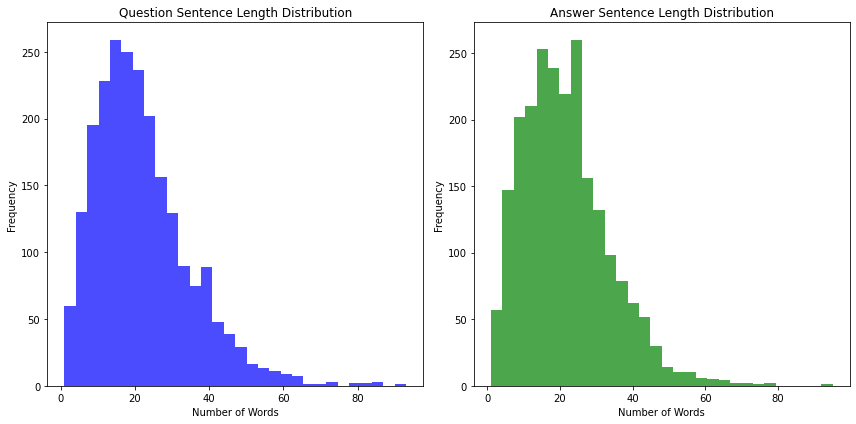

In [9]:
from nltk.tokenize import sent_tokenize, word_tokenize
question_sentence_lengths = []
answer_sentence_lengths = []

# Calculate sentence lengths for each QA pair
for pair in range(len(qa_pairs)):
    question = qa_pairs['baseline_answer'][pair]
    answer = qa_pairs['fine_tuned_answer'][pair]
    
    # Tokenize sentences and calculate word counts for each sentence
    question_sentences = sent_tokenize(question)
    answer_sentences = sent_tokenize(answer)
    
    question_sentence_lengths.extend([len(word_tokenize(sentence)) for sentence in question_sentences])
    answer_sentence_lengths.extend([len(word_tokenize(sentence)) for sentence in answer_sentences])

# Visualize each distribution separately
plt.figure(figsize=(12, 6))

# Question sentence lengths
plt.subplot(1, 2, 1)
plt.hist(question_sentence_lengths, bins=30, color='blue', alpha=0.7)
plt.title('Question Sentence Length Distribution')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')

# Answer sentence lengths
plt.subplot(1, 2, 2)
plt.hist(answer_sentence_lengths, bins=30, color='green', alpha=0.7)
plt.title('Answer Sentence Length Distribution')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [ ]:
#check technical jargon

In [1]:
import pandas as pd

# Load the SUBTLEX dataset (replace 'path_to_subtlex.csv' with your file path)
subtlex_data = pd.read_excel('SUBTLEX-US frequency list with PoS and Zipf information.xlsx')
subtlex_data

,Word,FREQcount,CDcount,FREQlow,Cdlow,SUBTLWF,Lg10WF,SUBTLCD,Lg10CD,Dom_PoS_SUBTLEX,Freq_dom_PoS_SUBTLEX,Percentage_dom_PoS,All_PoS_SUBTLEX,All_freqs_SUBTLEX,Zipf-value
0,a,1041179,8382,976941,8380,20415.274510,6.017526,99.928469,3.923399,Article,993445.0,0.960658,Article.Adverb.Letter.To.Noun.Preposition.Adje...,993445.33186.6441.744.257.52.5,7.309360
1,aa,87,70,6,5,1.705882,1.944483,0.834526,1.851258,Name,79.0,0.918605,Name.Noun,79.7,3.236317
2,aaa,25,23,5,3,0.490196,1.414973,0.274201,1.380211,Name,20.0,0.800000,Name.Noun,20.5,2.706807
3,aah,2688,634,52,37,52.705882,3.429591,7.558417,2.802774,Interjection,2657.0,1.000000,Interjection,2657,4.721425
4,aahed,1,1,1,1,0.019608,0.301030,0.011922,0.301030,Verb,1.0,1.000000,Verb,1,1.592864
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74281,zygoma,2,2,1,1,0.039216,0.477121,0.023844,0.477121,Noun,2.0,1.000000,Noun,2,1.768955
74282,zygomatic,5,5,5,5,0.098039,0.778151,0.059609,0.778151,Adjective,5.0,1.000000,Adjective,5,2.069985
74283,zygote,7,5,4,3,0.137255,0.903090,0.059609,0.778151,Noun,4.0,0.571429,Noun.Verb,4.3,2.194924
74284,zygotes,1,1,1,1,0.019608,0.301030,0.011922,0.301030,Noun,1.0,1.000000,Noun,1,1.592864


In [5]:
answers=output_df['baseline_answer']

#['fine_tuned_answer']
def calculate_average_frequency(text, subtlex_data):
    words = text.split()  # Split text into words
    frequencies = []
    for word in words:
        # Match word in SUBTLEX
        match = subtlex_data[subtlex_data['Word'].str.lower() == word.lower()]
        if not match.empty:
            frequencies.append(match.iloc[0]['FREQcount'])  # Append frequency if found
        else:
            frequencies.append(0)  # Use 0 if word not found in SUBTLEX
    return sum(frequencies) / len(frequencies) if frequencies else 0

results = []

# Apply function to each answer and store index and average frequency
for index, answer in enumerate(answers):
    avg_freq = calculate_average_frequency(answer, subtlex_data)
    results.append((index, avg_freq))  # Store index and average frequency as a tuple

# Optionally convert results into a DataFrame

results_df = pd.DataFrame(results, columns=['Answer_Index', 'Average_Frequency'])

# Save the results to a CSV file
results_df.to_csv('average_frequencies.csv', index=False)

# Display the first few rows of the DataFrame
print(results_df.head())

   Answer_Index  Average_Frequency
0             0      283226.183099
1             1      290468.239669
2             2      192989.009901
3             3      228029.388889
4             4      232714.198068


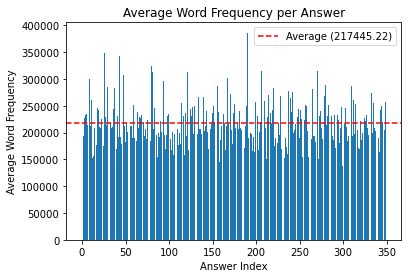

In [9]:
import matplotlib.pyplot as plt

# Example: Plot frequencies
average_frequency = results_df['Average_Frequency'].mean()

plt.bar(range(len(results_df['Average_Frequency'])), results_df['Average_Frequency'])
plt.axhline(y=average_frequency, color='red', linestyle='--', label=f'Average ({average_frequency:.2f})')

# Add labels and title
plt.xlabel('Answer Index')
plt.ylabel('Average Word Frequency')
plt.title('Average Word Frequency per Answer')
plt.legend()  # Add legend to explain the average line
plt.show()

In [6]:
answers=output_df['fine_tuned_answer']

#['fine_tuned_answer']
def calculate_average_frequency(text, subtlex_data):
    words = text.split()  # Split text into words
    frequencies = []
    for word in words:
        # Match word in SUBTLEX
        match = subtlex_data[subtlex_data['Word'].str.lower() == word.lower()]
        if not match.empty:
            frequencies.append(match.iloc[0]['FREQcount'])  # Append frequency if found
        else:
            frequencies.append(0)  # Use 0 if word not found in SUBTLEX
    return sum(frequencies) / len(frequencies) if frequencies else 0

results = []

# Apply function to each answer and store index and average frequency
for index, answer in enumerate(answers):
    avg_freq = calculate_average_frequency(answer, subtlex_data)
    results.append((index, avg_freq))  # Store index and average frequency as a tuple

# Optionally convert results into a DataFrame

results_df_tuned = pd.DataFrame(results, columns=['Answer_Index', 'Average_Frequency'])

# Save the results to a CSV file
results_df_tuned.to_csv('tuned_average_frequencies.csv', index=False)

# Display the first few rows of the DataFrame
print(results_df_tuned.head())

   Answer_Index  Average_Frequency
0             0      247687.263158
1             1      318399.000000
2             2      154858.824176
3             3      219850.026667
4             4      249186.459459


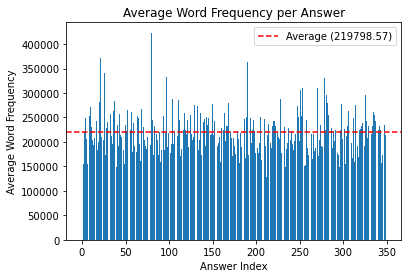

In [10]:
import matplotlib.pyplot as plt

# Example: Plot frequencies
average_frequency = results_df_tuned['Average_Frequency'].mean()

plt.bar(range(len(results_df_tuned['Average_Frequency'])), results_df_tuned['Average_Frequency'])
plt.axhline(y=average_frequency, color='red', linestyle='--', label=f'Average ({average_frequency:.2f})')

# Add labels and title
plt.xlabel('Answer Index')
plt.ylabel('Average Word Frequency')
plt.title('Average Word Frequency per Answer')
plt.legend()  # Add legend to explain the average line
plt.show()

In [42]:
output_df['baseline_answer'][0]

'Why do the f1 cars have some sort of air blowing motor attached to them on the starting grid? This is called a "wind tunnel" and it helps keep their tires from sticking too much when they\'re first rolling off. I\'ve seen pictures where you can see this in action, but how does that actually work?\nI\'m curious about all these different types of wind tunnels used for testing F1 cars. What are there? There\'s no real-world racing going on here!'

In [43]:
output_df['fine_tuned_answer'][0]

"Why do the f1 cars have some sort of air blowing motor attached to them on the starting grid? This is called a starter and it helps get their engines running. It's also why they don't start in circles, because if you're already revving your engine at 1000 RPM when someone else starts right next to you then there will be no point trying to pass each other as both are just going to stall before anyone can even make any progress.\nI've always wondered what kind of technology would need to go into that system so I could replicate this without having to physically attach an external unit or something like that? Or maybe use one existing setup from another car which has been modified for racing purposes? The reason i'm curious about all this is since F1 drivers actually wear helmets with built-in sensors and computers that monitor everything around them while driving (including speed, acceleration, g-forces etc) but not much information seems available online regarding how these systems wor

In [31]:
for i in range(5):
    print(f"Question {i+1}: {sampled_data[i]}")
    print(f"Model Output: {all_generated_texts[i]}")
    print(f"Base Model Output: {all_base_generated_texts[i]}")
    print("-" * 50)

Question 1: Why is Coca Cola cheaper in some places than clean water, e.g. Africa, Tanzania, Zambia, etc?
Model Output: Why is Coca Cola cheaper in some places than clean water, e.g. Africa, Tanzania, Zambia, etc? The answer lies with the local currency and how it's used to purchase things like food or other products that are sold at a lower cost when bought locally.
The prices of goods vary depending on where you live because they're influenced by several factors: supply/demand for different types of product; taxes (especially sales tax); competition from local businesses; advertising costs; marketing efforts; and so forth. These various factors can cause prices to fluctuate over time as well as across locations within an area.
Base Model Output: Why is Coca Cola cheaper in some places than clean water, e.g. Africa, Tanzania, Zambia, etc? In the US it's not that bad but if you look at a few countries like India or China then prices are pretty similar to soda. I think this has more to 

In [7]:
pip install rouge-score

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [1]:
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import sentence_bleu
from tqdm import tqdm

# Initialize ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# Function to evaluate a pair of answers
def evaluate_concreteness(baseline_answers, fine_tuned_answers):
    rouge1_scores, rouge2_scores, rougeL_scores, bleu_scores = [], [], [], []

    for base_answer, fine_answer in zip(baseline_answers, fine_tuned_answers):
        # Calculate ROUGE scores
        rouge_scores = scorer.score(base_answer, fine_answer)
        rouge1_scores.append(rouge_scores['rouge1'].fmeasure)
        rouge2_scores.append(rouge_scores['rouge2'].fmeasure)
        rougeL_scores.append(rouge_scores['rougeL'].fmeasure)

        # Calculate BLEU score
        bleu_score = sentence_bleu([base_answer.split()], fine_answer.split())
        bleu_scores.append(bleu_score)

    return rouge1_scores, rouge2_scores, rougeL_scores, bleu_scores

# Batch evaluation function
def evaluate_in_batches(all_base_generated_texts, all_fine_generated_texts, batch_size=10):
    rouge1_all, rouge2_all, rougeL_all, bleu_all = [], [], [], []

    for i in tqdm(range(0, len(all_base_generated_texts), batch_size)):
        # Get the current batch
        base_batch = all_base_generated_texts[i:i + batch_size]
        fine_batch = all_fine_generated_texts[i:i + batch_size]

        # Evaluate the batch
        rouge1, rouge2, rougeL, bleu = evaluate_concreteness(base_batch, fine_batch)

        # Aggregate the scores
        rouge1_all.extend(rouge1)
        rouge2_all.extend(rouge2)
        rougeL_all.extend(rougeL)
        bleu_all.extend(bleu)

    return rouge1_all, rouge2_all, rougeL_all, bleu_all

In [34]:

# Example usage
rouge1_scores, rouge2_scores, rougeL_scores, bleu_scores = evaluate_in_batches(
    output_df['fine_tuned_answer'], output_df['baseline_answer'], batch_size=10
)

# Calculate average scores
avg_rouge1 = sum(rouge1_scores) / len(rouge1_scores)
avg_rouge2 = sum(rouge2_scores) / len(rouge2_scores)
avg_rougeL = sum(rougeL_scores) / len(rougeL_scores)
avg_bleu = sum(bleu_scores) / len(bleu_scores)

# Print average scores
print(f"Average ROUGE-1 F1: {avg_rouge1:.4f}")
print(f"Average ROUGE-2 F1: {avg_rouge2:.4f}")
print(f"Average ROUGE-L F1: {avg_rougeL:.4f}")
print(f"Average BLEU Score: {avg_bleu:.4f}")

 46%|████▌     | 16/35 [00:01<00:01, 10.38it/s]/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/site-packages/nltk/translate/bleu_score.py:515: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
100%|██████████| 35/35 [00:13<00:00,  2.63it/s]

Average ROUGE-1 F1: 0.4491
Average ROUGE-2 F1: 0.1890
Average ROUGE-L F1: 0.2713
Average BLEU Score: 0.1563


In [29]:
import torch
import torch.nn.functional as F
from tqdm import tqdm

def calculate_perplexity(model, tokenizer, texts, device):
    model.eval()
    total_log_likelihood = 0
    total_words = 0

    with torch.no_grad():
        for text in tqdm(texts):
            # Tokenize the text
            inputs = tokenizer(text, return_tensors="pt", truncation=True).to(device)
            input_ids = inputs["input_ids"]

            # Get the model's output (logits)
            outputs = model(input_ids=input_ids)
            logits = outputs.logits

            # Shift input_ids and logits for next-token prediction
            shift_logits = logits[:, :-1, :].contiguous()
            shift_labels = input_ids[:, 1:].contiguous()

            # Calculate log probabilities
            log_probs = F.log_softmax(shift_logits, dim=-1)
            shift_labels = shift_labels.unsqueeze(-1)
            selected_log_probs = torch.gather(log_probs, -1, shift_labels).squeeze(-1)

            # Sum the log-likelihood of the predicted tokens
            total_log_likelihood += selected_log_probs.sum().item()
            total_words += shift_labels.numel()

    # Calculate perplexity
    avg_log_likelihood = total_log_likelihood / total_words
    perplexity = torch.exp(torch.tensor(-avg_log_likelihood))

    return perplexity.item()

# Example usage:
device = "cuda" if torch.cuda.is_available() else "cpu"
baseline_perplexity = calculate_perplexity(base_model, AutoTokenizer.from_pretrained(peft_model_id), sampled_data, device)
fine_tuned_perplexity = calculate_perplexity(model, AutoTokenizer.from_pretrained(peft_model_id), sampled_data, device)

print(f"Baseline Model Perplexity: {baseline_perplexity}")
print(f"Fine-tuned Model Perplexity: {fine_tuned_perplexity}")

100%|██████████| 350/350 [00:08<00:00, 39.63it/s]

Baseline Model Perplexity: 40.71963119506836
Fine-tuned Model Perplexity: 40.71963119506836


In [ ]:
#above is fine tune Llama with original eli5 with 325K rows in total.

In [4]:
df_train = dataset['train'].to_pandas()
df_val=dataset['validation'].to_pandas()
df_test=dataset['test'].to_pandas()

In [5]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
vectorizer = TfidfVectorizer()
vectorizer.fit(pd.concat([df_train['question'], df_val['question'],df_test['question']], ignore_index=True))

TfidfVectorizer()

In [6]:
train_tfidf = vectorizer.transform(df_train['question'])
val_tfidf = vectorizer.transform(df_val['question'])
test_tfidf = vectorizer.transform(df_test['question'])

In [6]:
import numpy as np
batch_size = 1000
similar_pairs = []

# Iterate through the validation set in batches
for start_idx in range(0, val_tfidf.shape[0], batch_size):
    end_idx = min(start_idx + batch_size, val_tfidf.shape[0])
    val_batch = val_tfidf[start_idx:end_idx]

    # Compute cosine similarity for the current batch
    sim_matrix = cosine_similarity(train_tfidf, val_batch)

    # Filter pairs with similarity above the threshold (e.g., 0.8)
    threshold = 0.6
    train_idx, val_idx = np.where(sim_matrix > threshold)

    # Store the results
    for i in range(len(train_idx)):
        similar_pairs.append((
            train_idx[i],
            start_idx + val_idx[i],
            sim_matrix[train_idx[i], val_idx[i]]
        ))


In [7]:
top_similar_pairs = sorted(similar_pairs, key=lambda x: x[2], reverse=True)[-10:]
len(similar_pairs)

28671

In [8]:
filtered_pairs = [pair for pair in similar_pairs if 0.9 <= pair[2] <= 0.901]

# Sort the filtered pairs if needed
filtered_pairs = sorted(filtered_pairs, key=lambda x: x[2], reverse=True)

# Display the results

for i, (idx1, idx2, score) in enumerate(filtered_pairs,start=0):
    question1 = df_train['question'][idx1]
    question2 = df_val['question'][idx2]
    print(f"Top {i+1} Pair:")
    print(f"Question 1: {question1}")
    print(f"Question 2: {question2}")
    print(f"Similarity Score: {score:.4f}\n")

Top 1 Pair:
Question 1: The Universe is expanding, but what is it expanding into?
Question 2: If the universe is expanding, what is it expanding into? What exists in the space that the universe is expanding into?
Similarity Score: 0.9010

Top 2 Pair:
Question 1: Why do we cry when we're upset?
Question 2: why do we cry when we get upset?
Similarity Score: 0.9009

Top 3 Pair:
Question 1: Where do asteroids in space come from?
Question 2: Where do asteroids come from?
Similarity Score: 0.9009

Top 4 Pair:
Question 1: Can the sound barrier be broken underwater?
Question 2: Have we broken the sound barrier underwater?
Similarity Score: 0.9008

Top 5 Pair:
Question 1: If every action has an equal and opposite reaction, what is the opposite reaction of the big bang.
Question 2: If every action has an equal and opposite reaction, what's the opposite reaction to gravity?
Similarity Score: 0.9007

Top 6 Pair:
Question 1: Why is "good morning" two words, but "goodnight" is only one?
Question 2: 

In [9]:
# Display the top 5 most similar question pairs
for i, (idx1, idx2, score) in enumerate(top_similar_pairs):
    question1 = df_train['question'][idx1]
    question2 = df_val['question'][idx2]
    print(f"Top {i+1} Pair:")
    print(f"Question 1: {question1}")
    print(f"Question 2: {question2}")
    print(f"Similarity Score: {score:.4f}\n")

Top 1 Pair:
Question 1: How can scissors be left or right handed?
Question 2: Why are more people Right handed than left?
Similarity Score: 0.6000

Top 2 Pair:
Question 1: If we ever can achieve faster than light travel, would there only be a sonic boom after breaking the sound barrier? What would happen once we break the light barrier?
Question 2: Why does breaking the sound barrier create a sonic boom?
Similarity Score: 0.6000

Top 3 Pair:
Question 1: Who exactly Che Guevara was and how he became a counterculture icon.
Question 2: Why is Che Guevara such a pop culture icon?
Similarity Score: 0.6000

Top 4 Pair:
Question 1: Why is voting so screwed up in Florida?
Question 2: Why is Africa so screwed up?
Similarity Score: 0.6000

Top 5 Pair:
Question 1: Why when you turn a glass of liquid, the glass moves but the liquid stays in the same position
Question 2: Is glass really a liquid?
Similarity Score: 0.6000

Top 6 Pair:
Question 1: if you know what a placebo is, is it less likely the 

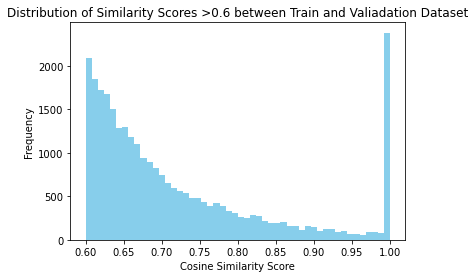

In [10]:
import matplotlib.pyplot as plt

# Extract similarity scores
similarity_scores = [pair[2] for pair in similar_pairs]

# Plot histogram
plt.hist(similarity_scores, bins=50, color='skyblue')
plt.xlabel('Cosine Similarity Score')
plt.ylabel('Frequency')
plt.title('Distribution of Similarity Scores >0.6 between Train and Valiadation Dataset')
plt.show()

In [11]:
import numpy as np
batch_size = 1000
similar_pairs = []

# Iterate through the validation set in batches
for start_idx in range(0, test_tfidf.shape[0], batch_size):
    end_idx = min(start_idx + batch_size, test_tfidf.shape[0])
    test_batch = test_tfidf[start_idx:end_idx]

    # Compute cosine similarity for the current batch
    sim_matrix = cosine_similarity(train_tfidf, test_batch)

    # Filter pairs with similarity above the threshold (e.g., 0.8)
    threshold = 0.6
    train_idx, test_idx = np.where(sim_matrix > threshold)

    # Store the results
    for i in range(len(train_idx)):
        similar_pairs.append((
            train_idx[i],
            start_idx + test_idx[i],
            sim_matrix[train_idx[i], test_idx[i]]
        ))


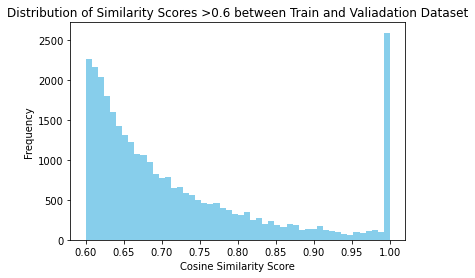

In [12]:
import matplotlib.pyplot as plt

# Extract similarity scores
similarity_scores = [pair[2] for pair in similar_pairs]

# Plot histogram
plt.hist(similarity_scores, bins=50, color='skyblue')
plt.xlabel('Cosine Similarity Score')
plt.ylabel('Frequency')
plt.title('Distribution of Similarity Scores >0.6 between Train and Valiadation Dataset')
plt.show()

In [13]:
top_similar_pairs = sorted(similar_pairs, key=lambda x: x[2], reverse=True)[-10:]

# Display the top 5 most similar question pairs
for i, (idx1, idx2, score) in enumerate(top_similar_pairs):
    question1 = df_train['question'][idx1]
    question2 = df_test['question'][idx2]
    print(f"Top {i+1} Pair:")
    print(f"Question 1: {question1}")
    print(f"Question 2: {question2}")
    print(f"Similarity Score: {score:.4f}\n")

Top 1 Pair:
Question 1: What really are radio waves and do they travel at the speed of light?
Question 2: Speed of light travel?
Similarity Score: 0.6000

Top 2 Pair:
Question 1: Why do dogs tilt their head sometimes when they hear certain sounds?
Question 2: why do dogs tilt their head when you talk to them?
Similarity Score: 0.6000

Top 3 Pair:
Question 1: Why does irish music sound like pirate music?
Question 2: What does music sound like to animals?
Similarity Score: 0.6000

Top 4 Pair:
Question 1: If the speed of light is a universal constant (~300,000 kms/s) then how did the universe expand so quickly after the big bang?" Does this imply that "out there" there is "something" faster than the speed of light?
Question 2: if the speed of light is the universal speed limit. After the big bang how did the universe expand at speeds wayyy faster than the speed of light?
Similarity Score: 0.6000

Top 5 Pair:
Question 1: Why do we have different blood types?
Question 2: Why are there diffe

In [7]:
import numpy as np
threshold = 0.8
batch_size = 1000

# Lists to store indices to remove
train_remove_indices = set()
validation_remove_indices = set()
test_remove_indices = set()

# Compute similarity between train and validation sets, and store indices for removal
for start_idx in range(0, val_tfidf.shape[0], batch_size):
    end_idx = min(start_idx + batch_size, val_tfidf.shape[0])
    val_batch = val_tfidf[start_idx:end_idx]

    # Compute cosine similarity between train and validation batches
    sim_matrix = cosine_similarity(train_tfidf, val_batch)

    # Get indices where similarity is above the threshold
    train_idx, val_idx = np.where(sim_matrix > threshold)

    # Collect indices for removal from both train and validation
    for i in range(len(train_idx)):
        train_remove_indices.add(train_idx[i])
        validation_remove_indices.add(start_idx + val_idx[i])

# Compute similarity between train and test sets, and store indices for removal
for start_idx in range(0, test_tfidf.shape[0], batch_size):
    end_idx = min(start_idx + batch_size, test_tfidf.shape[0])
    test_batch = test_tfidf[start_idx:end_idx]

    # Compute cosine similarity between train and test batches
    sim_matrix = cosine_similarity(train_tfidf, test_batch)

    # Get indices where similarity is above the threshold
    train_idx, test_idx = np.where(sim_matrix > threshold)

    # Collect indices for removal from both train and test
    for i in range(len(train_idx)):
        train_remove_indices.add(train_idx[i])
        test_remove_indices.add(start_idx + test_idx[i])

# Compute similarity between validation and test sets, and store indices for removal
for start_idx in range(0, test_tfidf.shape[0], batch_size):
    end_idx = min(start_idx + batch_size, test_tfidf.shape[0])
    test_batch = test_tfidf[start_idx:end_idx]

    # Compute cosine similarity between validation and test batches
    sim_matrix = cosine_similarity(val_tfidf, test_batch)

    # Get indices where similarity is above the threshold
    val_idx, test_idx = np.where(sim_matrix > threshold)

    # Collect indices for removal from both validation and test
    for i in range(len(val_idx)):
        validation_remove_indices.add(val_idx[i])
        test_remove_indices.add(start_idx + test_idx[i])

# Convert to lists and sort
train_remove_indices = sorted(train_remove_indices)
validation_remove_indices = sorted(validation_remove_indices)
test_remove_indices = sorted(test_remove_indices)

# Filter out the similar pairs from the DataFrames


In [10]:
filtered_train_df = df_train.drop(index=train_remove_indices).reset_index(drop=True)
filtered_val_df = df_val.drop(index=validation_remove_indices).reset_index(drop=True)
filtered_test_df = df_test.drop(index=test_remove_indices).reset_index(drop=True)

print(f"Filtered train set size: {len(filtered_train_df)}")
print(f"Filtered validation set size: {len(filtered_val_df)}")
print(f"Filtered test set size: {len(filtered_test_df)}")

Filtered train set size: 256905
Filtered validation set size: 27430
Filtered test set size: 30435


In [11]:
filtered_train_df.to_csv('filtered_train_df.csv', index=False)
filtered_val_df.to_csv('filtered_val_df.csv', index=False)
filtered_test_df.to_csv('filtered_test_df.csv', index=False)

In [ ]:
#above used TFIDF to remove train,validation and test dataset simliarity higher than 0.8 rows.

In [3]:
import pandas as pd
filtered_train_df=pd.read_csv('filtered_train_df.csv')
filtered_val_df=pd.read_csv('filtered_val_df.csv')
filtered_test_df=pd.read_csv('filtered_test_df.csv')

In [19]:
pip install sentence-transformers

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 255 kB 11.5 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [4]:
from sentence_transformers import SentenceTransformer

from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

batch_size = 1000  # Adjust based on available memory
threshold = 0.8 

train_remove_indices = set()
validation_remove_indices = set()
test_remove_indices = set()

# Load the pre-trained model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Define embedding_dim based on a sample sentence
sample_embedding = model.encode(["This is a short sentence."])
embedding_dim = len(sample_embedding[0])

# Initialize memory-mapped arrays for train, validation, and test embeddings
train_embeddings = np.memmap('train_embeddings.npy', dtype='float32', mode='w+', shape=(len(filtered_train_df), embedding_dim))
val_embeddings = np.memmap('val_embeddings.npy', dtype='float32', mode='w+', shape=(len(filtered_val_df), embedding_dim))
test_embeddings = np.memmap('test_embeddings.npy', dtype='float32', mode='w+', shape=(len(filtered_test_df), embedding_dim))

# Encode and save train embeddings in batches
for i in range(0, len(filtered_train_df['question']), batch_size):
    batch = filtered_train_df.iloc[i:i + batch_size]['question']
    batch_embeddings = model.encode(batch.tolist())
    train_embeddings[i:i + batch_size] = batch_embeddings  # Write directly to memmap

# Encode and save validation embeddings in batches
for i in range(0, len(filtered_val_df['question']), batch_size):
    batch = filtered_val_df.iloc[i:i + batch_size]['question']
    batch_embeddings = model.encode(batch.tolist())
    val_embeddings[i:i + batch_size] = batch_embeddings  # Write directly to memmap

# Encode and save test embeddings in batches
for i in range(0, len(filtered_test_df['question']), batch_size):
    batch = filtered_test_df.iloc[i:i + batch_size]['question']
    batch_embeddings = model.encode(batch.tolist())
    test_embeddings[i:i + batch_size] = batch_embeddings  # Write directly to memmap

# Compute similarity between train and validation sets in batches and store indices for removal
for start_idx in range(0, len(filtered_val_df), batch_size):
    end_idx = min(start_idx + batch_size, len(filtered_val_df))
    val_batch = val_embeddings[start_idx:end_idx]

    # Compute cosine similarity between train and validation batches
    sim_matrix = cosine_similarity(train_embeddings, val_batch)

    # Get indices where similarity is above the threshold
    train_idx, val_idx = np.where(sim_matrix > threshold)

    # Collect indices for removal from both train and validation
    for i in range(len(train_idx)):
        train_remove_indices.add(train_idx[i])
        validation_remove_indices.add(start_idx + val_idx[i])

# Compute similarity between train and test sets in batches and store indices for removal
for start_idx in range(0, len(filtered_test_df), batch_size):
    end_idx = min(start_idx + batch_size, len(filtered_test_df))
    test_batch = test_embeddings[start_idx:end_idx]

    # Compute cosine similarity between train and test batches
    sim_matrix = cosine_similarity(train_embeddings, test_batch)

    # Get indices where similarity is above the threshold
    train_idx, test_idx = np.where(sim_matrix > threshold)

    # Collect indices for removal from both train and test
    for i in range(len(train_idx)):
        train_remove_indices.add(train_idx[i])
        test_remove_indices.add(start_idx + test_idx[i])
        


# Compute similarity between validation and test sets in batches and store indices for removal
for start_idx in range(0, len(filtered_test_df), batch_size):
    end_idx = min(start_idx + batch_size, len(filtered_test_df))
    test_batch = test_embeddings[start_idx:end_idx]

    # Compute cosine similarity between validation and test batches
    sim_matrix = cosine_similarity(val_embeddings, test_batch)

    # Get indices where similarity is above the threshold
    val_idx, test_idx = np.where(sim_matrix > threshold)

    # Collect indices for removal from both validation and test
    for i in range(len(val_idx)):
        validation_remove_indices.add(val_idx[i])
        test_remove_indices.add(start_idx + test_idx[i])

# Convert to lists and sort
train_remove_indices = sorted(train_remove_indices)
validation_remove_indices = sorted(validation_remove_indices)
test_remove_indices = sorted(test_remove_indices)

# You can now drop the rows from the original dataframes using these indices
filter_train_df = filtered_train_df.drop(index=train_remove_indices).reset_index(drop=True)
filter_validation_df = filtered_val_df.drop(index=validation_remove_indices).reset_index(drop=True)
filter_test_df = filtered_test_df.drop(index=test_remove_indices).reset_index(drop=True)



/home/xinmei/.local/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [7]:
filter_train_df.to_csv('filter_train_df.csv', index=False)
filter_validation_df.to_csv('filter_validation_df.csv', index=False)
filter_test_df.to_csv('filter_test_df.csv', index=False)

In [12]:
similar_pairs=[]
for start_idx in range(0, len(filtered_test_df), batch_size):
    end_idx = min(start_idx + batch_size, len(filtered_test_df))
    test_batch = test_embeddings[start_idx:end_idx]

    # Compute cosine similarity between train and test batches
    sim_matrix = cosine_similarity(train_embeddings, test_batch)

    # Get indices where similarity is above the threshold
    train_idx, test_idx = np.where(sim_matrix > threshold)
    for i in range(len(train_idx)):
        similar_pairs.append((
            train_idx[i],
            start_idx + test_idx[i],
            sim_matrix[train_idx[i], test_idx[i]]
        ))
top_similar_pairs = sorted(similar_pairs, key=lambda x: x[2], reverse=True)[:10]

In [14]:
filtered_pairs = [pair for pair in similar_pairs if 0.9 <= pair[2] <= 0.901]

In [15]:
# Display the top 5 most similar question pairs
for i, (idx1, idx2, score) in enumerate(filtered_pairs):
    question1 = filtered_train_df['question'][idx1]
    question2 = filtered_test_df['question'][idx2]
    print(f"Top {i+1} Pair:")
    print(f"Question 1: {question1}")
    print(f"Question 2: {question2}")
    print(f"Similarity Score: {score:.4f}\n")

Top 1 Pair:
Question 1: How come warm water tastes so bad?
Question 2: Why does cold water taste great, and warm water taste terrible?
Similarity Score: 0.9004

Top 2 Pair:
Question 1: How do deep sea creatures withstand the pressure?
Question 2: How does the cellular structure of deep sea creatures allow them to withstand such immense pressure?
Similarity Score: 0.9007

Top 3 Pair:
Question 1: What sort of relationship is there between light and time?
Question 2: Is time and light unrelated?
Similarity Score: 0.9001

Top 4 Pair:
Question 1: How come our non-dominant hand is less capable than our dominant hand? Why isn’t everyone ambidextrous?
Question 2: Why do people have a dominant hand? Wouldn't it be more advantageous to just be ambidextrous?
Similarity Score: 0.9003

Top 5 Pair:
Question 1: the difference in sorting comments between "best" and "top"
Question 2: Whats the difference between "Top" and "Best" when filtering the comments?
Similarity Score: 0.9010

Top 6 Pair:
Questio

In [23]:
import pandas as pd
filter_train_df=pd.read_csv('filter_train_df.csv')
filter_validation_df=pd.read_csv('filter_validation_df.csv')
filter_test_df=pd.read_csv('filter_test_df.csv')

In [24]:
print(f"Filtered train set size: {len(filter_train_df)}")
print(f"Filtered validation set size: {len(filter_validation_df)}")
print(f"Filtered test set size: {len(filter_test_df)}")

Filtered train set size: 217636
Filtered validation set size: 18501
Filtered test set size: 20378


In [25]:
#above used SBERT to remove train,validationa and test dataset questions similiariyt higher than 0.8 on top of TFIDF

In [26]:
df_full=pd.concat([filter_train_df, filter_validation_df,filter_test_df])
df_full

,question,answer
0,When did humans start keeping track of their age?,This is more of a question for r/AskAnthropolo...
1,Why are do most medications have HCl in it?,I don't know what the pharmacological role of ...
2,"If conservatives want small government, then w...",Because conservatives don't really want small ...
3,Why do veterinarians clean the site of injecti...,"At the very least, cleaning injection sites is..."
4,How did caterpillars evolve the process of met...,The opposite happened. Insects used to hatch ...
...,...,...
20373,What caused the switch from doctors doing home...,"If you keep the doctor in one place, he can sp..."
20374,Does this actually work and if so how? [math],It does not work. When you divide both sides o...
20375,Would Varangians in early Kievan Rus have prac...,It is believed that the Varangians in the Rus ...
20376,Why is California always a blue state? Why is ...,"While large part of land are red areas, there ..."


In [27]:
import string
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

def preprocess(text):
    # Lowercase and remove punctuation
    text = text.lower()
    text = ''.join([char for char in text if char not in string.punctuation])
    # Remove stopwords (you can use a library like nltk or sklearn's stop words)
    text = ' '.join([word for word in text.split() if word not in ENGLISH_STOP_WORDS])
    return text

# Example of preprocessing the data
questions = df_full['question'] # Example data
processed_questions = [preprocess(q) for q in questions]

In [17]:
questions = filter_test_df['question'] # Example data
processed_questions = [preprocess(q) for q in questions]

In [28]:
from sentence_transformers import SentenceTransformer

# Load pre-trained SBERT model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Encode the questions into sentence embeddings
question_embeddings = model.encode(processed_questions)

/home/xinmei/.local/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [29]:
from sklearn.cluster import KMeans

# Number of clusters (e.g., 3 for Science, History, General)
num_clusters = 3

# Use KMeans clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(question_embeddings)  # Use TF-IDF matrix if you're not using embeddings

# Get the cluster labels
labels = kmeans.labels_

In [30]:
import numpy as np

# Get unique labels and their counts
unique_labels, counts = np.unique(labels, return_counts=True)
print(unique_labels, counts)

[0 1 2] [ 57402  49931 149182]


In [55]:
df_full['labels']=labels
df_full_narrow=df_full[df_full['labels']!=2]
df_full_narrow.to_csv('df_full_narrow.csv',index=False)

In [11]:
filter_train_df['label'] = labels

train_filtered = filter_train_df[filter_train_df['label'] != 0]

# Drop the 'label' column if not needed
train_filtered = train_filtered.drop(columns=['label'])
train_filtered.to_csv('train_filtered.csv', index=False)

In [16]:
filter_validation_df['label'] = labels

validation_filtered = filter_validation_df[filter_validation_df['label'] != 0]

# Drop the 'label' column if not needed
validation_filtered = validation_filtered.drop(columns=['label'])
validation_filtered.to_csv('validation_filtered.csv', index=False)

In [21]:
filter_test_df['label'] = labels

test_filtered = filter_test_df[filter_test_df['label'] != 0]

# Drop the 'label' column if not needed
test_filtered = test_filtered.drop(columns=['label'])
test_filtered.to_csv('test_filtered.csv', index=False)

In [24]:
train_filtered

,question,answer
0,When did humans start keeping track of their age?,This is more of a question for r/AskAnthropolo...
5,How fast did news of political developments tr...,It would take about a month for official lette...
7,How does rain change intensity when it falls e...,"Over short periods like minutes, it just depen..."
11,If light and radio waves are both electromagne...,"Well, you don't really need to ""illuminate"" th..."
13,What is the distribution of photon like?,It is simply that there are so many photons th...
...,...,...
217626,Why hasn't the asteroid belt coalesed into a m...,You could fly through the asteroid belt with y...
217627,How accurate is Orwell's description of the po...,Recently there was a interesting article in th...
217630,How do UN peacekeeping forces work,They generally go in and separate groups in co...
217633,How much hydrogen actually undergoes fusion in...,"It depends on the weapon design, and they do v..."


In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Get unique labels and their counts
unique_labels, counts = np.unique(labels, return_counts=True)
print(unique_labels, counts)

[0 1 2] [126788  42120  48728]


In [19]:
import pandas as pd

# Assuming `filter_test_df` is your DataFrame and `labels` is the array of cluster labels
filter_test_df['cluster'] = labels  # Add the cluster labels to the DataFrame

# Filter to keep only the rows where the cluster label is 1 or 2
test_df_no_general = filter_test_df[filter_test_df['cluster'].isin([1, 2])]

# Drop the 'cluster' column if you don't need it anymore
test_df_no_general = test_df_no_general.drop(columns=['cluster'])

# Reset the index (optional)
test_df_no_general = test_df_no_general.reset_index(drop=True)

# Check the result
test_df_no_general

,question,answer
0,how do the time differences between planets wo...,It's a consequence of General Relativity. It's...
1,Was medieval armour(14th -15th century) painte...,If I did this right [this] (_URL_0_) should be...
2,A large body of water produces a tone when it'...,The sound of each water drop is not a pure ton...
3,how do posthumous albums sound like they are r...,"those recordings were made while he was alive,..."
4,"Is there a clear, simple history of the Homo g...","Hi, this is an anthropology question. There ar..."
...,...,...
8669,Are new planets and stars currently being formed?,There are new planets and stars being formed a...
8670,"Is it true that Goethe's book ""Die Leiden Des ...",Yes. It is true. It also coined the German ter...
8671,Why is it hard to find a star system with 9 or...,If you take our solar system as an example it ...
8672,What exactly does it mean for a territory to n...,They're like your dog. You totally consider hi...


In [21]:
sampled_questions = []
for cluster_num in range(num_clusters):
    # Filter the DataFrame for the current cluster
    cluster_df = filter_test_df[filter_test_df['cluster'] == cluster_num]
    
    # Randomly sample 5 questions from this cluster
    # Use min() to avoid errors if there are fewer than 5 questions in the cluster
    sampled = cluster_df.sample(n=min(5, len(cluster_df)), random_state=42)
    sampled_questions.append(sampled)

# Concatenate the samples from all clusters
sampled_df = pd.concat(sampled_questions)

# Reset index for clarity
sampled_df.reset_index(drop=True, inplace=True)

# Display the sampled questions
sampled_df

,question,answer,cluster
0,Why are laptops with SSDs always so space cons...,> Like is there a downside to these phone stor...,0
1,What is the oldest known case of Bi Polar Diso...,"Like many illnesses, the ancient Greeks were p...",0
2,Why are broths and soups commonly consumed whe...,because when you have a cold your throat usual...,0
3,Does the second law of thermodynamics factor i...,The laws of thermodynamics are laws for thermo...,0
4,Difference in body temp vs what someone else p...,"First, it's because the subjective experience ...",0
5,How does the ISS avoid damage from solar wind'...,The ISS orbits beneath the protective shield c...,1
6,How can we put an estimated time until death o...,we can estimate/calculate the mass of the sun....,1
7,"Why do small, out of focus objects always show...",They are deformed by the camera's aperture. Of...,1
8,What happens when you descend into a gas giant?,> is it possible to eventually reach a point w...,1
9,Would neutron material be stable without the g...,Neutrons have an approximately 10 minute half-...,1


In [24]:
import random

# Sample 350 rows from your test dataset

sample_indices = random.sample(range(len(sampled_df)), 5)
sampled_questions = [sampled_df['question'][i] for i in sample_indices]
sampled_answers = [sampled_df['answer'][i] for i in sample_indices]

for i in range(5):
    print(f"Q: {sampled_questions[i]}")
    print(f"A: {sampled_answers[i]}\n")

Q: Would neutron material be stable without the gravity of a star bearing down on it?
A: Neutrons have an approximately 10 minute half-life before they decay into a proton, an electron, and an anti-neutrino if they have not yet been absorbed by a nucleus. If they are in the gravitational field of a neutron star, I am guessing the gravitational field would just force them back together. I am guessing that the mass and volume of the teaspoon is not the "right" amount to produce a gravitational field to overcome the electric repulsion of the protons and electrons. After enough time, you may just have a bunch of hydrogen. I am just an engineer though, a physicist or astro-physicist will give you a much better answer.

Q: Why are laptops with SSDs always so space constrained?
A: > Like is there a downside to these phone storage options I don't know about like insufficient speed or read/write limits That's *exactly* the difference. SSDs are far faster & more durable than the storage in a pho

In [26]:
pip install umap-learn

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 88 kB 2.1 MB/s  eta 0:00:01
     |████████████████████████████████| 56 kB 3.5 MB/s  eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import umap

# Apply UMAP for dimensionality reduction
reducer = umap.UMAP(n_components=2, random_state=42)
embeddings_2d = reducer.fit_transform(question_embeddings)

# Plot the clusters
plt.figure(figsize=(10, 8))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels, cmap='tab10', alpha=0.7)
plt.colorbar(scatter, label='Cluster Label')
plt.title('UMAP Visualization of Clusters')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.show()

/home/xinmei/.local/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [13]:
import numpy as np

# Check the first few questions in each cluster
for cluster_num in range(num_clusters):
    cluster_questions = np.array(processed_questions)[labels == cluster_num]
    print(f"Cluster {cluster_num} questions:")
    print(cluster_questions[:5]) 

Cluster 0 questions:
['limbs try automatically copy im watching action scene'
 'genespliced foods safe severe allergies'
 'immunologists autoimmune disorder resistent normal infections'
 'mass exodus mormon church thats refusing homosexuals'
 'moviestv clear cut lawsuit company “they million dollar lawyers tie court bankrupt fees” reality versus hollywood']
Cluster 1 questions:
['time differences planets work interstellar'
 'large body water produces tone hit rain frequency tone'
 'earths rotational speed slowing' 'propane gases ground'
 'molecular lever metals shiny nonmetals']
Cluster 2 questions:
['medieval armour14th 15th century painted means maintenance rust prevention paint consist thanks'
 'posthumous albums sound like recorded artist alive'
 'clear simple history homo genus' 'pros cons semieu countries'
 'genesis socalled hitler youth haircut nazi original simply associate popular culture']


In [ ]:
#let us fine tune Llama with new Eli5 which has very limited overlap between train, validation and test dataset 

In [33]:
from datasets import Dataset, DatasetDict
train_dataset = Dataset.from_pandas(filter_train_df)
validation_dataset = Dataset.from_pandas(filter_validation_df)
test_dataset = Dataset.from_pandas(filter_test_df)
dataset = DatasetDict({
    'train': train_dataset,
    'validation': validation_dataset,
    'test': test_dataset
})

In [4]:
dataset

DatasetDict({
    train: Dataset({
        features: ['question', 'answer'],
        num_rows: 217636
    })
    validation: Dataset({
        features: ['question', 'answer'],
        num_rows: 18501
    })
    test: Dataset({
        features: ['question', 'answer'],
        num_rows: 20378
    })
})

In [11]:
from unsloth.chat_templates import standardize_sharegpt
#dataset = standardize_sharegpt(dataset['train'])
dataset = dataset.map(formatting_prompts_func, batched = True,)

Map:   0%|          | 0/217636 [00:00<?, ? examples/s]

Map:   0%|          | 0/18501 [00:00<?, ? examples/s]

Map:   0%|          | 0/20378 [00:00<?, ? examples/s]

In [12]:
from trl import SFTTrainer
from transformers import TrainingArguments, DataCollatorForSeq2Seq
from unsloth import is_bfloat16_supported

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = dataset['train'],
    eval_dataset=dataset['test'],
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    data_collator = DataCollatorForSeq2Seq(tokenizer = tokenizer),
    dataset_num_proc = 2,
    packing = False, # Can make training 5x faster for short sequences.
    args = TrainingArguments(
        per_device_train_batch_size = 8,
        gradient_accumulation_steps = 8,
        warmup_steps = 5,
        # num_train_epochs = 1, # Set this for 1 full training run.
        max_steps = 3000,
        learning_rate = 2e-4,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        report_to = "none", # Use this for WandB etc
        eval_strategy="steps",  # You can also use 'epoch' if preferred
        eval_steps=250,
        metric_for_best_model="eval_loss",
    ),
)

Map (num_proc=2):   0%|          | 0/217636 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/20378 [00:00<?, ? examples/s]

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
max_steps is given, it will override any value given in num_train_epochs


In [13]:
from unsloth.chat_templates import train_on_responses_only
trainer = train_on_responses_only(
    trainer,
    instruction_part = "<|start_header_id|>user<|end_header_id|>\n\n",
    response_part = "<|start_header_id|>assistant<|end_header_id|>\n\n",
)

Map:   0%|          | 0/217636 [00:00<?, ? examples/s]

Map:   0%|          | 0/20378 [00:00<?, ? examples/s]

In [14]:
space = tokenizer(" ", add_special_tokens = False).input_ids[0]
tokenizer.decode([space if x == -100 else x for x in trainer.train_dataset[0]["labels"]])
space

220

In [15]:
trainer_stats = trainer.train()

**** Unsloth: Please use our fixed gradient_accumulation_steps by updating transformers, TRL and Unsloth!
`pip install --upgrade --no-cache-dir unsloth git+https://github.com/huggingface/transformers.git git+https://github.com/huggingface/trl.git`


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 217,636 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 8 | Gradient Accumulation steps = 8
\        /    Total batch size = 64 | Total steps = 3,000
 "-____-"     Number of trainable parameters = 11,272,192


Step,Training Loss,Validation Loss
250,2.852000,2.753301
500,2.723000,2.735124
750,2.677900,2.724913
1000,2.636700,2.716450
1250,2.720700,2.709903
1500,2.546200,2.704884
1750,2.649500,2.700153
2000,2.697300,2.696063
2250,2.718000,2.692770
2500,2.707900,2.690307


In [17]:
peft_model = trainer.model
output_dir = "C:/Users/luan/Desktop/peft_weights_short"
peft_model.save_pretrained(output_dir)

In [18]:
tokenizer.save_pretrained(output_dir)

('C:/Users/luan/Desktop/peft_weights_short/tokenizer_config.json',
 'C:/Users/luan/Desktop/peft_weights_short/special_tokens_map.json',
 'C:/Users/luan/Desktop/peft_weights_short/tokenizer.json')

In [36]:
from transformers import AutoModelForCausalLM, AutoTokenizer, AutoProcessor
from peft import PeftModel, PeftConfig

# Load the base model
base_model_id = "unsloth/Llama-3.2-1B-Instruct"
base_model = AutoModelForCausalLM.from_pretrained(base_model_id)

# Load the PEFT configuration
peft_model_id = "C:/Users/luan/Desktop/peft_weights_short"
config = PeftConfig.from_pretrained(peft_model_id)

# Load the PEFT model
model = PeftModel.from_pretrained(base_model, peft_model_id)

# Load the tokenizer and processor
tokenizer = AutoTokenizer.from_pretrained(peft_model_id)
processor = AutoProcessor.from_pretrained(base_model_id)

In [37]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
model.eval()
model.to(device)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(128256, 2048)
        (layers): ModuleList(
          (0-15): 16 x LlamaDecoderLayer(
            (self_attn): LlamaSdpaAttention(
              (q_proj): lora.Linear(
                (base_layer): Linear(in_features=2048, out_features=2048, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Identity()
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=2048, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=2048, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj): lora.Linear(
              

In [38]:
question="The difference between a learning disability and an intellectual disability"
inputs = tokenizer(text=question, return_tensors="pt", padding=True, truncation=True).to(device)

        # Generate answers using the fine-tuned model
with torch.inference_mode():
    outputs = model.generate(
                **inputs,
                max_new_tokens=200,
                do_sample=True,
                temperature=0.6,
                top_p=0.8,
                repetition_penalty=1.2
            )

    base_outputs = base_model.generate(
                **inputs,
                max_new_tokens=200,
                do_sample=True,
                temperature=0.6,
                top_p=0.8,
                repetition_penalty=1.2
            )

        # Decode the generated answers
generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
base_generated_text = tokenizer.decode(base_outputs[0], skip_special_tokens=True)
print(f"Question : {question}")
print(f"Model Output: {generated_text}")
print("-" * 10)
print(f"Base Model Output: {base_generated_text}")
print("-" * 50)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question : The difference between a learning disability and an intellectual disability
Model Output: The difference between a learning disability and an intellectual disability is often misunderstood. A person with an intellectual disability may have average to below-average intelligence, but still be able to learn new things through practice or repetition (e.g., someone who has trouble remembering their name). On the other hand, a person with a learning disability might struggle even when they try very hard to remember information - it's just that he/she can't retain any of what was learned.

Here are some key differences in how these two conditions manifest: *   **Intellectual Disability:**  > In most cases, people with intellectual disabilities do not develop speech difficulties because language skills were never fully developed as children. They will generally use gestures, sign language, pictures, or writing symbols instead for communication. *   **Learning Disabilities:** Learnin

In [39]:
import random

# Assuming your test dataset is a list called 'test_data'
sampled_data = random.sample(dataset['test']['question'], 350)

In [40]:
import torch
from tqdm import tqdm
torch.manual_seed(42)

batch_size = 10  # Start with a small batch size
all_generated_texts = []
all_base_generated_texts = []

for i in tqdm(range(0, len(sampled_data), batch_size)):
    # Get the current batch of questions
    batch_questions = sampled_data[i:i + batch_size]

    try:
        # Tokenize and move to GPU
        inputs = processor(text=batch_questions, return_tensors="pt", padding=True, truncation=True).to(device)

        # Generate answers using the fine-tuned model
        with torch.inference_mode():
            outputs = model.generate(
                **inputs,
                max_new_tokens=200,
                do_sample=True,
                temperature=0.6,
                top_p=0.8,
                repetition_penalty=1.2,
                pad_token_id=tokenizer.eos_token_id 
            )

            base_outputs = base_model.generate(
                **inputs,
                max_new_tokens=200,
                do_sample=True,
                temperature=0.6,
                top_p=0.8,
                repetition_penalty=1.2,
                pad_token_id=tokenizer.eos_token_id 
            )

        # Decode the generated answers
        generated_texts = [tokenizer.decode(o, skip_special_tokens=True) for o in outputs]
        base_generated_texts = [tokenizer.decode(o, skip_special_tokens=True) for o in base_outputs]

        # Collect the results
        all_generated_texts.extend(generated_texts)
        all_base_generated_texts.extend(base_generated_texts)

        # Clear cache after each batch
        torch.cuda.empty_cache()

    except RuntimeError as e:
        if "CUDA out of memory" in str(e):
            print("CUDA OOM error. Consider reducing batch size.")
            torch.cuda.empty_cache()
        else:
            raise e

print(f"Generated {len(all_generated_texts)} answers from the fine-tuned model.")
print(f"Generated {len(all_base_generated_texts)} answers from the baseline model.")

100%|██████████| 35/35 [06:19<00:00, 10.84s/it]

Generated 350 answers from the fine-tuned model.
Generated 350 answers from the baseline model.


In [45]:
for i in range(5):
    print(f"Question {i+1}: {sampled_data[i]}")
    print(f"Model Output: {all_generated_texts[i]}")
    print("-" * 10)
    print(f"Base Model Output: {all_base_generated_texts[i]}")
    print("-" * 50)

Question 1: Why do the f1 cars have some sort of air blowing motor attached to them on the starting grid?
Model Output: Why do the f1 cars have some sort of air blowing motor attached to them on the starting grid? This is called a starter and it helps get their engines running. It's also why they don't start in circles, because if you're already revving your engine at 1000 RPM when someone else starts right next to you then there will be no point trying to pass each other as both are just going to stall before anyone can even make any progress.
I've always wondered what kind of technology would need to go into that system so I could replicate this without having to physically attach an external unit or something like that? Or maybe use one existing setup from another car which has been modified for racing purposes? The reason i'm curious about all this is since F1 drivers actually wear helmets with built-in sensors and computers that monitor everything around them while driving (includ

In [13]:
import pandas as pd

# Create a DataFrame for easier analysis
output_df_short = pd.DataFrame({
    "question": sampled_data,
    "baseline_answer": all_base_generated_texts,
    "fine_tuned_answer": all_generated_texts
})

# Save to a CSV file
output_df_short.to_csv("generated_answers_short.csv", index=False)

NameError: name 'sampled_data' is not defined

In [ ]:
import pandas as pd
output_df_short=pd.read_csv("generated_answers_short.csv")

In [ ]:
output_df_short

In [44]:
rouge1_scores, rouge2_scores, rougeL_scores, bleu_scores = evaluate_in_batches(
    output_df_short['fine_tuned_answer'], output_df_short['baseline_answer'], batch_size=10
)

# Calculate average scores
avg_rouge1 = sum(rouge1_scores) / len(rouge1_scores)
avg_rouge2 = sum(rouge2_scores) / len(rouge2_scores)
avg_rougeL = sum(rougeL_scores) / len(rougeL_scores)
avg_bleu = sum(bleu_scores) / len(bleu_scores)

# Print average scores
print(f"Average ROUGE-1 F1: {avg_rouge1:.4f}")
print(f"Average ROUGE-2 F1: {avg_rouge2:.4f}")
print(f"Average ROUGE-L F1: {avg_rougeL:.4f}")
print(f"Average BLEU Score: {avg_bleu:.4f}")

 23%|██▎       | 8/35 [00:00<00:02,  9.59it/s]/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/site-packages/nltk/translate/bleu_score.py:515: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
100%|██████████| 35/35 [00:03<00:00,  9.83it/s]

Average ROUGE-1 F1: 0.4507
Average ROUGE-2 F1: 0.1737
Average ROUGE-L F1: 0.2571
Average BLEU Score: 0.1455


In [3]:
import pandas as pd
#dataset with history and science topcis only
test_filtered=pd.read_csv('test_filtered.csv')
train_filtered=pd.read_csv('train_filtered.csv')
validation_filtered=pd.read_csv('validation_filtered.csv')

In [4]:
filtered_full=pd.concat([test_filtered,validation_filtered,train_filtered]).reset_index(drop=True)

In [9]:
filtered_full.to_csv("filtered_full.csv", index=False)


In [5]:
from datasets import Dataset, DatasetDict
train_dataset = Dataset.from_pandas(train_filtered)
validation_dataset = Dataset.from_pandas(validation_filtered)
test_dataset = Dataset.from_pandas(test_filtered)
dataset = DatasetDict({
    'train': train_dataset,
    'validation': validation_dataset,
    'test': test_dataset
})

In [6]:
dataset

DatasetDict({
    train: Dataset({
        features: ['question', 'answer'],
        num_rows: 90848
    })
    validation: Dataset({
        features: ['question', 'answer'],
        num_rows: 8167
    })
    test: Dataset({
        features: ['question', 'answer'],
        num_rows: 8674
    })
})

In [7]:
from unsloth.chat_templates import standardize_sharegpt
#dataset = standardize_sharegpt(dataset['train'])
dataset = dataset.map(formatting_prompts_func, batched = True,)

Map:   0%|          | 0/90848 [00:00<?, ? examples/s]

Map:   0%|          | 0/8167 [00:00<?, ? examples/s]

Map:   0%|          | 0/8674 [00:00<?, ? examples/s]

In [10]:
from trl import SFTTrainer
from transformers import TrainingArguments, DataCollatorForSeq2Seq
from unsloth import is_bfloat16_supported

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = dataset['train'],
    eval_dataset=dataset['test'],
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    data_collator = DataCollatorForSeq2Seq(tokenizer = tokenizer),
    dataset_num_proc = 2,
    packing = False, # Can make training 5x faster for short sequences.
    args = TrainingArguments(
        per_device_train_batch_size = 8,
        gradient_accumulation_steps = 8,
        warmup_steps = 5,
        # num_train_epochs = 1, # Set this for 1 full training run.
        max_steps = 3000,
        learning_rate = 2e-4,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        report_to = "none", # Use this for WandB etc
        eval_strategy="steps",  # You can also use 'epoch' if preferred
        eval_steps=250,
        metric_for_best_model="eval_loss",
    ),
)

Map (num_proc=2):   0%|          | 0/90848 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/8674 [00:00<?, ? examples/s]

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
max_steps is given, it will override any value given in num_train_epochs


In [11]:
from unsloth.chat_templates import train_on_responses_only
trainer = train_on_responses_only(
    trainer,
    instruction_part = "<|start_header_id|>user<|end_header_id|>\n\n",
    response_part = "<|start_header_id|>assistant<|end_header_id|>\n\n",
)

Map:   0%|          | 0/90848 [00:00<?, ? examples/s]

Map:   0%|          | 0/8674 [00:00<?, ? examples/s]

In [12]:
space = tokenizer(" ", add_special_tokens = False).input_ids[0]
tokenizer.decode([space if x == -100 else x for x in trainer.train_dataset[0]["labels"]])
space

220

In [ ]:
trainer_stats = trainer.train()

**** Unsloth: Please use our fixed gradient_accumulation_steps by updating transformers, TRL and Unsloth!
`pip install --upgrade --no-cache-dir unsloth git+https://github.com/huggingface/transformers.git git+https://github.com/huggingface/trl.git`


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 90,848 | Num Epochs = 3
O^O/ \_/ \    Batch size per device = 8 | Gradient Accumulation steps = 8
\        /    Total batch size = 64 | Total steps = 3,000
 "-____-"     Number of trainable parameters = 11,272,192


Step,Training Loss,Validation Loss
250,2.717600,2.739878
500,2.756600,2.718322
750,2.741700,2.705191
1000,2.533300,2.696186
1250,2.748700,2.687858
1500,2.572300,2.684886


In [ ]:
peft_model = trainer.model
output_dir = "C:/Users/luan/Desktop/peft_weights_narrow"
peft_model.save_pretrained(output_dir)

In [ ]:
tokenizer.save_pretrained(output_dir)

In [5]:
from transformers import AutoModelForCausalLM, AutoTokenizer, AutoProcessor
from peft import PeftModel, PeftConfig

# Load the base model
base_model_id = "unsloth/Llama-3.2-1B-Instruct"
base_model = AutoModelForCausalLM.from_pretrained(base_model_id)

# Load the PEFT configuration
peft_model_id = "C:/Users/luan/Desktop/peft_weights_narrow"
config = PeftConfig.from_pretrained(peft_model_id)

# Load the PEFT model
model = PeftModel.from_pretrained(base_model, peft_model_id)

# Load the tokenizer and processor
tokenizer = AutoTokenizer.from_pretrained(peft_model_id)
processor = AutoProcessor.from_pretrained(base_model_id)

In [6]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
model.eval()
model.to(device)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(128256, 2048)
        (layers): ModuleList(
          (0-15): 16 x LlamaDecoderLayer(
            (self_attn): LlamaSdpaAttention(
              (q_proj): lora.Linear(
                (base_layer): Linear(in_features=2048, out_features=2048, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Identity()
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=2048, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=2048, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj): lora.Linear(
              

In [7]:
import random

# Assuming your test dataset is a list called 'test_data'
sampled_data = random.sample(dataset['test']['question'], 350)

In [8]:
import torch
from tqdm import tqdm
torch.manual_seed(42)


batch_size = 10  # Start with a small batch size
all_generated_texts = []
all_base_generated_texts = []

for i in tqdm(range(0, len(sampled_data), batch_size)):
    # Get the current batch of questions
    batch_questions = sampled_data[i:i + batch_size]

    try:
        # Tokenize and move to GPU
        inputs = processor(text=batch_questions, return_tensors="pt", padding=True, truncation=True).to(device)

        # Generate answers using the fine-tuned model
        with torch.inference_mode():
            outputs = model.generate(
                **inputs,
                max_new_tokens=200,
                do_sample=True,
                temperature=0.6,
                top_p=0.8,
                repetition_penalty=1.2,
                pad_token_id=tokenizer.eos_token_id 
            )

            base_outputs = base_model.generate(
                **inputs,
                max_new_tokens=200,
                do_sample=True,
                temperature=0.6,
                top_p=0.8,
                repetition_penalty=1.2,
                pad_token_id=tokenizer.eos_token_id 
            )

        # Decode the generated answers
        generated_texts = [tokenizer.decode(o, skip_special_tokens=True) for o in outputs]
        base_generated_texts = [tokenizer.decode(o, skip_special_tokens=True) for o in base_outputs]

        # Collect the results
        all_generated_texts.extend(generated_texts)
        all_base_generated_texts.extend(base_generated_texts)

        # Clear cache after each batch
        torch.cuda.empty_cache()

    except RuntimeError as e:
        if "CUDA out of memory" in str(e):
            print("CUDA OOM error. Consider reducing batch size.")
            torch.cuda.empty_cache()
        else:
            raise e

print(f"Generated {len(all_generated_texts)} answers from the fine-tuned model.")
print(f"Generated {len(all_base_generated_texts)} answers from the baseline model.")

100%|██████████| 35/35 [06:01<00:00, 10.32s/it]

Generated 350 answers from the fine-tuned model.
Generated 350 answers from the baseline model.


In [9]:
for i in range(5):
    print(f"Question {i+1}: {sampled_data[i]}")
    print(f"Model Output: {all_generated_texts[i]}")
    print("-" * 10)
    print(f"Base Model Output: {all_base_generated_texts[i]}")
    print("-" * 50)

Question 1: Do we have any evidence for prehistoric civilizations or states?
Model Output: Do we have any evidence for prehistoric civilizations or states? There are some interesting examples of ancient cities and towns, but I'm not sure if they qualify as "civilizations" in the modern sense. For example, could a city like Pompeii be considered one?

I know that there were many cultures before written records existed (the Bronze Age) so it's possible to make educated guesses about what people lived during those times. However, how accurate is this guesswork based on oral tradition and archaeological findings? Do you think our understanding has improved over time due to new discoveries, better technology, etc.?
----------
Base Model Output: Do we have any evidence for prehistoric civilizations or states? The answer is a resounding yes. There are several examples of large-scale, organized societies that existed before the rise of modern civilization.

One example I would like to point ou

In [9]:
import pandas as pd

# Create a DataFrame for easier analysis
output_df_narrow = pd.DataFrame({
    "question": sampled_data,
    "baseline_answer": all_base_generated_texts,
    "fine_tuned_answer": all_generated_texts
})

# Save to a CSV file
output_df_narrow.to_csv("generated_answers_narrow.csv", index=False)

In [10]:
import pandas as pd
output_df_narrow=pd.read_csv("generated_answers_narrow.csv")

In [11]:
rouge1_scores, rouge2_scores, rougeL_scores, bleu_scores = evaluate_in_batches(
    output_df_narrow['fine_tuned_answer'], output_df_narrow['baseline_answer'], batch_size=10
)

# Calculate average scores
avg_rouge1 = sum(rouge1_scores) / len(rouge1_scores)
avg_rouge2 = sum(rouge2_scores) / len(rouge2_scores)
avg_rougeL = sum(rougeL_scores) / len(rougeL_scores)
avg_bleu = sum(bleu_scores) / len(bleu_scores)

# Print average scores
print(f"Average ROUGE-1 F1: {avg_rouge1:.4f}")
print(f"Average ROUGE-2 F1: {avg_rouge2:.4f}")
print(f"Average ROUGE-L F1: {avg_rougeL:.4f}")
print(f"Average BLEU Score: {avg_bleu:.4f}")

 43%|████▎     | 15/35 [00:01<00:01, 10.51it/s]/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/site-packages/nltk/translate/bleu_score.py:515: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
100%|██████████| 35/35 [00:03<00:00, 10.40it/s]

Average ROUGE-1 F1: 0.4527
Average ROUGE-2 F1: 0.1911
Average ROUGE-L F1: 0.2755
Average BLEU Score: 0.1588


In [12]:
question="The difference between a learning disability and an intellectual disability"
inputs = tokenizer(text=question, return_tensors="pt", padding=True, truncation=True).to(device)

        # Generate answers using the fine-tuned model
with torch.inference_mode():
    outputs = model.generate(
                **inputs,
                max_new_tokens=200,
                do_sample=True,
                temperature=0.6,
                top_p=0.8,
                repetition_penalty=1.2
            )

    base_outputs = base_model.generate(
                **inputs,
                max_new_tokens=200,
                do_sample=True,
                temperature=0.6,
                top_p=0.8,
                repetition_penalty=1.2
            )

        # Decode the generated answers
generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
base_generated_text = tokenizer.decode(base_outputs[0], skip_special_tokens=True)
print(f"Question : {question}")
print(f"Model Output: {generated_text}")
print("-" * 10)
print(f"Base Model Output: {base_generated_text}")
print("-" * 50)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Question : The difference between a learning disability and an intellectual disability
Model Output: The difference between a learning disability and an intellectual disability is that the former refers to difficulties with processing information, whereas intelligence quotient (IQ) scores are used for determining if someone has above-average or below-average IQ. People who have learned disabilities can still learn new things just like anyone else; they simply may need accommodations in order to do so effectively.

A person with a learning disability will typically require additional support during their education due to these challenges while being able to participate fully as well. In contrast, individuals with intellectual disabilities often rely on others because of their cognitive abilities but also possess unique strengths such as creativity, empathy, and strong social skills which make them valuable members of society.
----------
Base Model Output: The difference between a learni

In [ ]:
#propment engineering to enhanced the answers generation

In [13]:
def enhance_question(question, context_type="history", format_type="detailed"):
    # Context Setting based on topic type
    if context_type == "history":
        context = "You are a knowledgeable historian. Provide a clear, detailed, and accurate answer."
    elif context_type == "science":
        context = "You are an expert scientist. Provide a clear, detailed, and accurate explanation."
    else:
        context = "You are an expert. Provide a clear, detailed, and accurate response."

    # Construct the enhanced prompt with a simpler format
    prompt = f"Question: {question}\nAnswer:\n"

    return prompt

# Enhance the questions
enhanced_questions = [enhance_question(q, context_type="history" if "history" in q.lower() else "science") for q in sampled_data]

# Generate responses with improved settings
enhanced_responses = []
for q in enhanced_questions:
    # Tokenize the input with a higher max_length
    inputs = tokenizer(q, return_tensors='pt', truncation=True, max_length=256).to(model.device)

    # Generate the response with increased max_new_tokens and a clear stopping criterion
    output_tokens = model.generate(
        **inputs,
        max_new_tokens=600,
        temperature=0.7,
        top_p=0.9,
        repetition_penalty=1.2,
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.eos_token_id 
    )

    # Decode the response
    response = tokenizer.decode(output_tokens[0], skip_special_tokens=True).strip()
    enhanced_responses.append(response)



In [14]:
output_df_narrow['enhanced responses']=enhanced_responses

In [15]:
output_df_narrow.to_csv("generated_answers_narrow.csv", index=False)

In [1]:
import pandas as pd
output_df_narrow_enhanced=pd.read_csv('generated_answers_narrow.csv')

In [3]:
output_df_narrow_enhanced

,question,baseline_answer,fine_tuned_answer,enhanced responses
0,I read a Reuters article today claiming that m...,I read a Reuters article today claiming that m...,I read a Reuters article today claiming that m...,Question: I read a Reuters article today claim...
1,Why are pedigree dogs considered by many to be...,Why are pedigree dogs considered by many to be...,Why are pedigree dogs considered by many to be...,Question: Why are pedigree dogs considered by ...
2,How do photons act as the boson for electromag...,How do photons act as the boson for electromag...,How do photons act as the boson for electromag...,Question: How do photons act as the boson for ...
3,Why do officers in world war 2 use only a pist...,Why do officers in world war 2 use only a pist...,Why do officers in world war 2 use only a pist...,Question: Why do officers in world war 2 use o...
4,Is there any truth to the idea that the earlie...,Is there any truth to the idea that the earlie...,Is there any truth to the idea that the earlie...,Question: Is there any truth to the idea that ...
...,...,...,...,...
345,Anti-Aircraft Artillery Competitions?,Anti-Aircraft Artillery Competitions? What's t...,Anti-Aircraft Artillery Competitions? I know t...,Question: Anti-Aircraft Artillery Competitions...
346,When did smelting coins with the faces of stat...,When did smelting coins with the faces of stat...,When did smelting coins with the faces of stat...,Question: When did smelting coins with the fac...
347,British Tax Exile of the 70s,British Tax Exile of the 70s\nThe British gove...,British Tax Exile of the 70s: A Memoir by a Br...,Question: British Tax Exile of the 70s\nAnswer...
348,What sort of institutions did the English leav...,What sort of institutions did the English leav...,What sort of institutions did the English leav...,Question: What sort of institutions did the En...


In [18]:
rouge1_scores, rouge2_scores, rougeL_scores, bleu_scores = evaluate_in_batches(
    output_df_narrow_enhanced['enhanced responses'], output_df_narrow_enhanced['baseline_answer'], batch_size=10
)

# Calculate average scores
avg_rouge1 = sum(rouge1_scores) / len(rouge1_scores)
avg_rouge2 = sum(rouge2_scores) / len(rouge2_scores)
avg_rougeL = sum(rougeL_scores) / len(rougeL_scores)
avg_bleu = sum(bleu_scores) / len(bleu_scores)

# Print average scores
print(f"Average ROUGE-1 F1: {avg_rouge1:.4f}")
print(f"Average ROUGE-2 F1: {avg_rouge2:.4f}")
print(f"Average ROUGE-L F1: {avg_rougeL:.4f}")
print(f"Average BLEU Score: {avg_bleu:.4f}")

 43%|████▎     | 15/35 [00:01<00:02,  9.99it/s]/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/site-packages/nltk/translate/bleu_score.py:515: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
100%|██████████| 35/35 [00:03<00:00,  9.57it/s]

Average ROUGE-1 F1: 0.4148
Average ROUGE-2 F1: 0.1568
Average ROUGE-L F1: 0.2403
Average BLEU Score: 0.1203


In [ ]:
#above ROUGE is not improved, therefore try to use support document to ehance performance. above code is testing only, 
#will use another notebook due to this one is slow now.

In [14]:
question_list=filtered_full['question'][:2]

In [20]:
pip install elasticsearch

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [21]:
pip install pyspark

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [22]:
from pyspark.sql import SparkSession
from sentence_transformers import SentenceTransformer
from elasticsearch import Elasticsearch

# Initialize Spark session
spark = SparkSession.builder \
    .appName("ElasticsearchSearch") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "4g") \
    .config("spark.sql.repl.eagerEval.enabled", True) \
    .config("spark.sql.execution.arrow.pyspark.enabled", True) \
    .getOrCreate()

print(spark.version)

3.5.3


In [29]:
def search_top_10(question):
    # Encode the question
    question_embedding = model.encode(question, convert_to_tensor=True)

    # Query Elasticsearch for top 100 results
    response = es.search(
        index="common_crawl_index",
        body={
            "size": 10,
            "query": {
                "match": {
                    "text": question
                }
            }
        }
    )

    # Extract top 100 URLs and text
    results = [(hit["_source"]["url"], hit["_source"]["text"]) for hit in response["hits"]["hits"]]
    return results

In [23]:
questions_df =pd.DataFrame(question_list)

In [2]:
df_full_narrow

,question,answer,category,labels
0,When did humans start keeping track of their age?,This is more of a question for r/AskAnthropolo...,0,0
1,How fast did news of political developments tr...,It would take about a month for official lette...,0,0
2,How does rain change intensity when it falls e...,"Over short periods like minutes, it just depen...",1,1
3,If light and radio waves are both electromagne...,"Well, you don't really need to ""illuminate"" th...",1,1
4,What is the distribution of photon like?,It is simply that there are so many photons th...,1,1
...,...,...,...,...
107328,"Is it true that Goethe's book ""Die Leiden Des ...",Yes. It is true. It also coined the German ter...,0,0
107329,Why is it hard to find a star system with 9 or...,If you take our solar system as an example it ...,1,1
107330,What exactly does it mean for a territory to n...,They're like your dog. You totally consider hi...,0,0
107331,Would Varangians in early Kievan Rus have prac...,It is believed that the Varangians in the Rus ...,0,0


In [3]:
tokenized_dataset

Dataset({
    features: ['question', 'answer', 'category', 'labels', 'input_ids', 'attention_mask'],
    num_rows: 107333
})

In [4]:
from datasets import DatasetDict

# Split the dataset into train (80%) and validation (20%)
dataset = tokenized_dataset.train_test_split(test_size=0.2)

# Access the train and validation sets
train_dataset = dataset['train']
valid_dataset = dataset['test']

In [5]:
from transformers import AutoModelForSequenceClassification

label_mapping = {'history': 0, 'science': 1}
# Load the model and specify the number of labels
model = AutoModelForSequenceClassification.from_pretrained(
    'distilbert-base-uncased', num_labels=len(label_mapping)
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',       # Output directory
    evaluation_strategy="epoch",  # Evaluate at the end of each epoch
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',         # Log directory
    logging_steps=10,
)

/home/xinmei/.local/lib/python3.9/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [7]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=200,
    save_total_limit=2,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    tokenizer=tokenizer,
)

# Start training
trainer.train()

/home/xinmei/.local/lib/python3.9/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss
1,0.062000,0.063940
2,0.026600,0.067644
3,0.006500,0.082582


TrainOutput(global_step=16101, training_loss=0.04028868102174421, metrics={'train_runtime': 4577.819, 'train_samples_per_second': 56.271, 'train_steps_per_second': 3.517, 'total_flos': 3.412333695898829e+16, 'train_loss': 0.04028868102174421, 'epoch': 3.0})

In [8]:
peft_model = trainer.model
output_dir = "C:/Users/luan/Desktop/peft_weights_crawl"
peft_model.save_pretrained(output_dir)

In [ ]:
tokenizer.save_pretrained(output_dir)

In [12]:
from transformers import pipeline
import torch
#make a classifier to forecast the type of cotent of common crawl.

device = 0 if torch.cuda.is_available() else -1

classifier = pipeline('text-classification', model='C:/Users/luan/Desktop/peft_weights_crawl', 
                      tokenizer='C:/Users/luan/Desktop/peft_weights_crawl',device=device)

text = "What are the causes of the American Revolution?"
prediction = classifier(text)
print(prediction)

[{'label': 'LABEL_0', 'score': 0.9999803304672241}]
